# Canny Edge Detection in Python

## Author: Soham Phanse

## Blog: https://medium.com/@soham.phanse/canny-edge-detection-in-python-4cbc1209adbc

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits import mplot3d
import copy
import seaborn as sns

# Generic Functions

Here we write some generic functions we can make use of later

(Acknowledging Prof. Bourke's work at https://github.com/mgb45/ECE4076/blob/main/Week%201%20-%20Image%20handling%20and%20basic%20operations.ipynb)

In [ ]:
'''
Function name: normalize_img
Input: Single image, dtype: numpy array
Output: Single image, dtype: numpy array
'''

def normalize_image(im_crop):

  img_red = im_crop[:, :, 0]
  img_green = im_crop[:, :, 1]
  img_blue = im_crop[:, :, 2]

  mu_red, sd_red = np.mean(img_red), np.std(img_red)
  mu_green, sd_green = np.mean(img_green), np.std(img_green)
  mu_blue, sd_blue = np.mean(img_blue), np.std(img_blue)

  im_op = 1/3*((img_red-mu_red)/sd_red + (img_green-mu_green)/sd_green + (img_blue-mu_blue)/sd_blue)

  return im_op

In [ ]:
'''
Function name: entropy
Input: Single image, dtype: numpy array
Output: float
'''

def entropy(im):
    prob, bins = np.histogram(im.ravel(),density=True,bins=np.linspace(0,255,255,dtype=int))
    prob = prob+1e-12 # Add a small non-zero probability to avoid log(0) problems
    entropy = -np.sum(np.log2(prob)*prob)
    return entropy

# Task 1: Implement a function to perform convolution

A convolution opertion between an image of size M $\times$ N and a kernel of size m $\times$ n results into an image with (M - m +1) $\times$ (N - n + 1). The mathematical operation is defined as follows:

$$ O(i, j) = \sum^m_{k=1}\sum^n_{l=1} I(i+k-1, j+l-1)*K(k, l)$$

where $O(i, j)$ is the resultant imamge, I(i, j) is the test image and K(k, l) is the kernel.

In [ ]:
def conv(im, kernel):

    im2 = copy.deepcopy(im)

    # store the number of rows and columns in kernel
    (krows, kcols) = np.shape(kernel)

    # store the number of rows and columns in the test image, ensure the image is normalized
    (imrows, imcols) = np.shape(im2)

    # After convolution the resultant image has (imrows - krows + 1) rows and (imcols - kcols + 1) columns
    ## Create a matrix of the sie to store the result
    result = np.zeros([imrows - krows + 1, imcols - kcols + 1])

    # Implement the convolution mathematics (check markdown cell above for mathematical explanation)
    for i in range(imrows-krows):
      for j in range(imcols-kcols):
        for k in range(krows):
          for l in range(kcols):
            result[i, j] += im2[i+k-1, j+l-1]*kernel[k, l]

    return result

In [ ]:
# store the kernel values
r1, r2, r3 = np.array([2, 4, 5, 4, 2]), np.array([4, 9, 12, 9, 4]), np.array([5, 12, 15, 12, 5])
kernel = np.matrix([r1, r2, r3, r2, r1])

# load the image and normalize it
img = normalize_image(cv.imread('zebra.jpg'))

# Call the gaussian blurring function and store the result
gaussblur_img = conv(img, kernel)

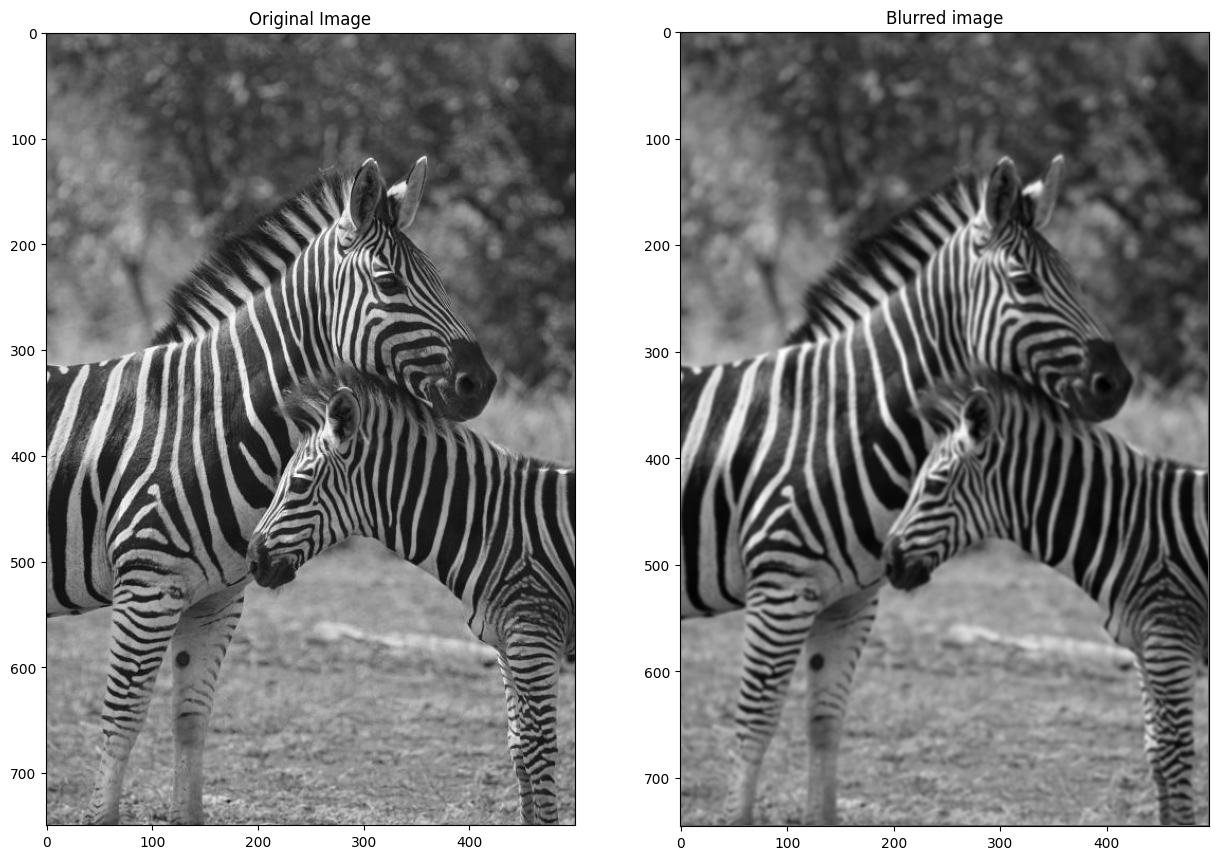

In [ ]:
# Show results here
## plot the original and blurred images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(gaussblur_img, cmap='gray')
#plt.title('Original Image');
ax2.set_title('Blurred image');

# Task 2: Calculate the image gradients

We already have the gaussian blurred image from Task 1, we will just reuse it here and do further processing.


In [ ]:
 # define the x gradient calculation sobel filter
r1 = np.array([-1, 0, 1])
sobel = 1/8*np.matrix([r1, 2*r1, r1])

gradx = conv(gaussblur_img, sobel)
grady = conv(gaussblur_img, np.transpose(sobel))

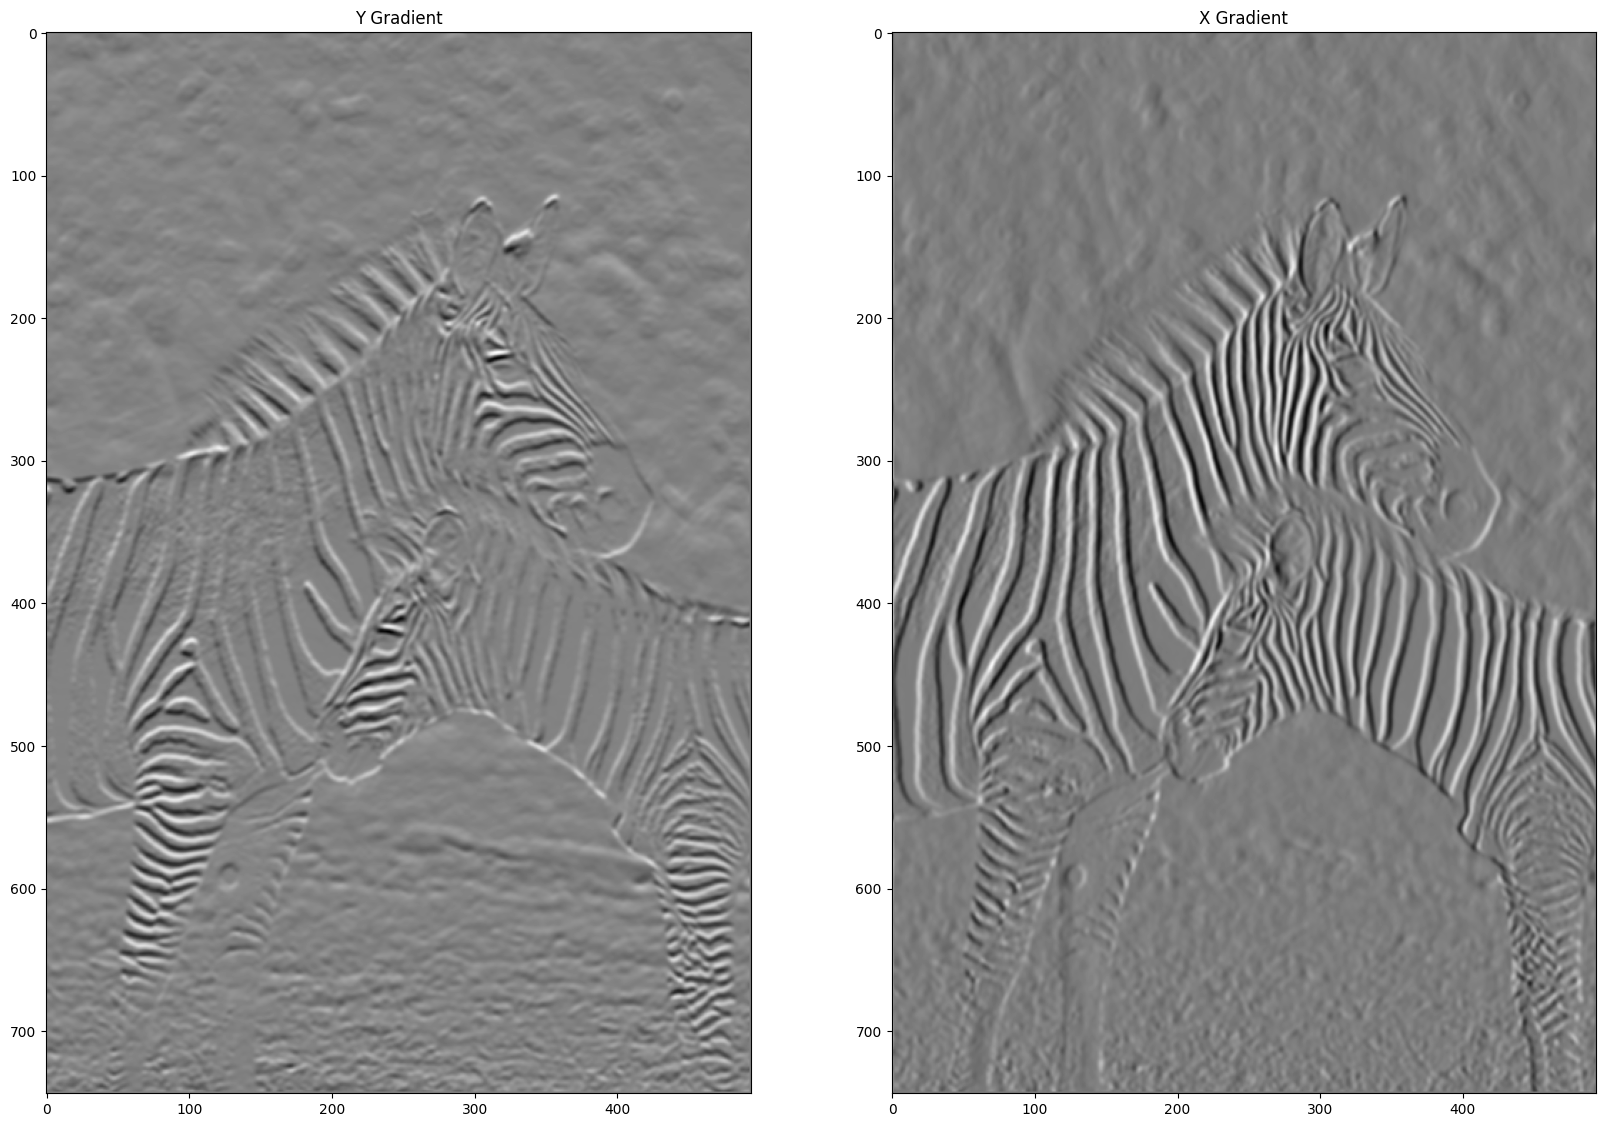

In [ ]:
# visualize results
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(grady, cmap='gray')
ax[0].set_title('Y Gradient')
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('X Gradient');

In [ ]:
# Demonstrate your understanding by answering the question below:
# Looking at the filter coefficients, explain how a sobel filter picks out horizontal edges?


# Task 3: Calculate gradient magnitude

In [ ]:
'''
Function Name: gradmagnitude
Input:
1. Image, Type: numpy array
2. sobel: filter to be used for gradient calculations
Output:[grad_mag, gradx, grady]
1. Array:
  1.1 Gradient magnitude, X gradient, Y gradient, Type: numpy array
'''

def gradmagnitude(img, sobel):
  gradx = conv(img, sobel)
  grady = conv(img, np.transpose(sobel))
  grad_mag = (gradx**2 + grady**2)**0.5
  return [grad_mag, gradx, grady]

In [ ]:
# Write your code here
grad_magnitude_data = gradmagnitude(gaussblur_img, sobel)
gms = np.shape(grad_magnitude_data[0])

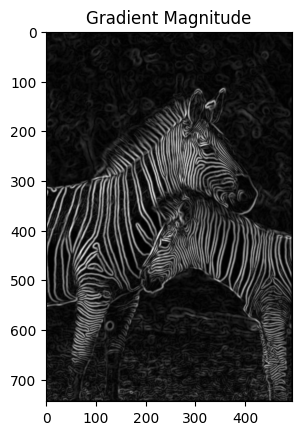

In [ ]:
# Show results here
plt.imshow(grad_magnitude_data[0], cmap='gray')
plt.title('Gradient Magnitude');

In [ ]:
# Demonstrate your understanding by answering the question below:
# What differences in gradient magnitude would be observed for a corner, edge and solid region?

## Corner:

## Edge:

## Solid region:

# Task 4: Calculate gradient orientation

## Function 'gradoreoround'

Calculates X and Y gradients, gradient magnitude, gradient orientation and rounds them off

In [ ]:
'''
Function name: gradoreoround
Function description: rounds the orientation values to the nearest specified angle values

Input
1. img: image whose gradient orientation is to be calculated
2. sobel: filter to be used for gradient calculation in x direction
3. val: return type of solution
  3.1 default value: 'rad': values will be returned in radians
  3.2 other allowed arguments: 'deg': values will be returned in degrees
4. roundval: angle value intervals to be rounded off to, default value: 45

Output:
1. array: [rounded_grad_oreo, grad_only_oreo, grad_oreo_all[1], grad_oreo_all[2]]
  1.1 Rounded off gradient orientation
  1.2 unrounded gradient orientation
  1.3 X gradient
  1.4 Y gradient
  1.5 Gradient magnitude
'''

def gradoreoround(img, sobel, val='rad', roundval=45):

  # create gradient
  gradx = conv(img, sobel)
  grady = conv(img, np.transpose(sobel))

  # create gradient magnitude
  grad_mag = (gradx**2 + grady**2)**0.5

  # create gradient orientation

  ## create a small value matrix to ensure division by zero can be avoided, use the same size as that of the image
  small_val = np.ones(np.shape(gradx))*1e-3

  ## define the tan inverse operation to calculate gradient orientation
  grad_oreo = np.arctan2(grady, (gradx+small_val))

  ## Converting grad_oreo from radians to degrees
  if val=='deg':
    grad_oreo = grad_oreo*180/np.pi

  # #define round off operation
  rounded_grad_oreo = np.ceil((np.floor(grad_oreo/(roundval*0.5)))/2)*roundval

  '''
  Rounding can be done with this another method
  godrs = np.shape(godr)
  for i in range(godrs[0]):
    for j in range(godrs[1]):
      if godr[i, j]%2==0:
        godr[i, j] = godr[i, j]/2
      else:
        godr[i, j] = (godr[i, j] + 1)/2
  '''

  return rounded_grad_oreo, grad_oreo, gradx, grady, grad_mag

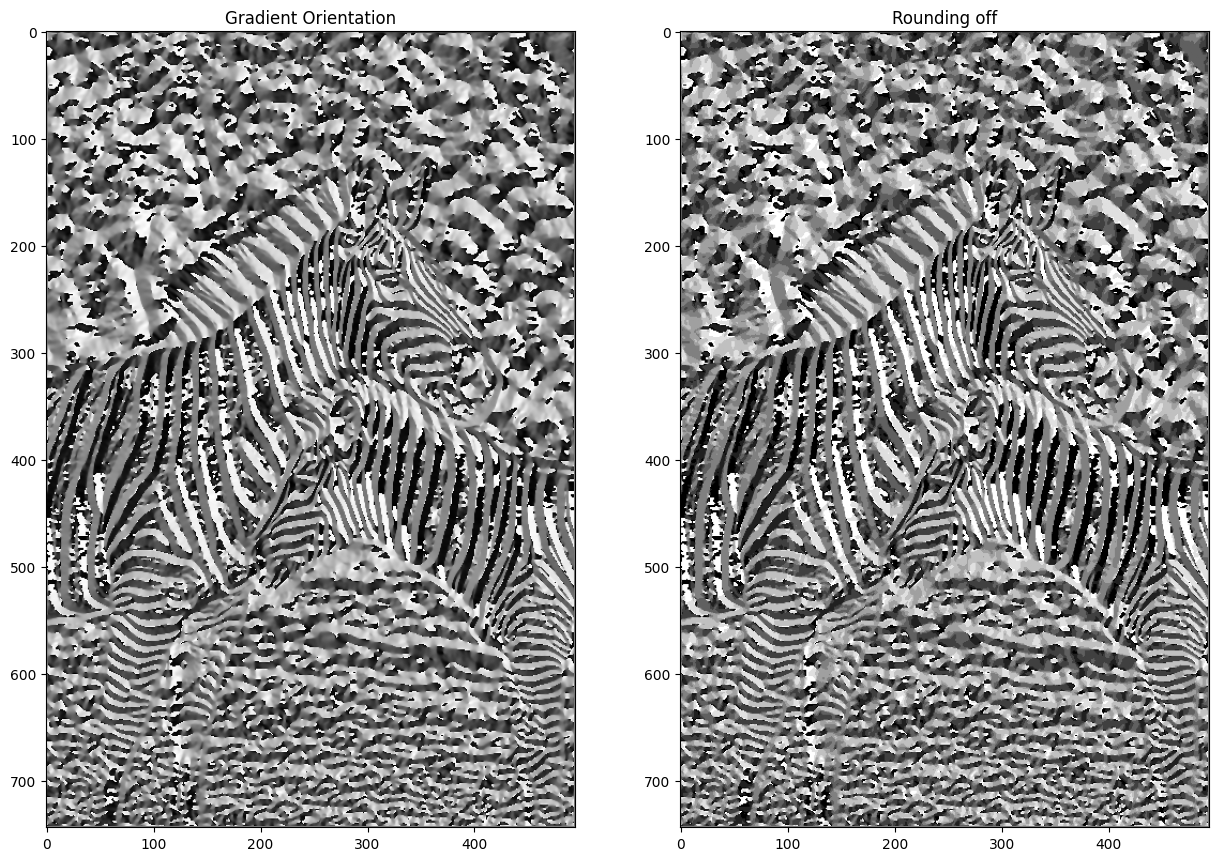

In [ ]:
grad_orientation_data = gradoreoround(gaussblur_img, sobel, 'deg', 45)

# Show results here
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(grad_orientation_data[1], cmap='gray')
ax[1].imshow(grad_orientation_data[0], cmap='gray')
ax[0].set_title('Gradient Orientation')
ax[1].set_title('Rounding off');

Now there are about 300 pixels in both the vertical and horizontal directions, which when seen together, we can't really differentiate if the rounding has really happened.

However, if we just plot a small patch of the image then we will see the stark difference. We demonstrate the same as follows:

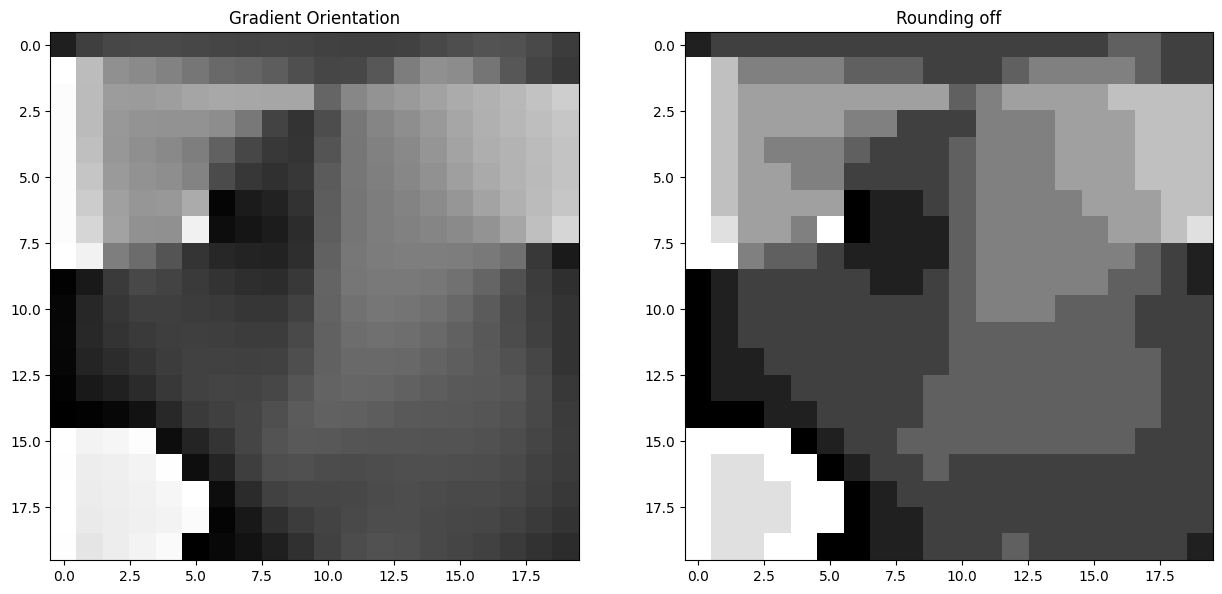

In [ ]:
# Show results here
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(grad_orientation_data[1][0:20, 0:20], cmap='gray')
ax[1].imshow(grad_orientation_data[0][0:20, 0:20], cmap='gray')
ax[0].set_title('Gradient Orientation')
ax[1].set_title('Rounding off');

In [ ]:
# Demonstrate your understanding by answering the question below:
# How could the gradient orientation be used to obtain rotational invariance for patch matching?


# Task 5: Extend your code to perform non-maximal suppression

Explanation: (documenting for myself, to refer later for revision)

So, until now, we have completed a blurred image. Then we found out X and Y gradients of the image. We then found out the magnitudes and approximate directions.

Now in the non maximum suppression, what we will be doing is as follows:

- Step 0: Lets start from pixel at position [i, j]. Name this pixel as 'P'.
- Step 1: Access the approximated gradient direction of the pixel.
- Step 2: Calculate the directiosn perpendicular to this gradient direction. Say, if the gradient angle is 90, then the perpendicular directions are going to be along 0 and 180. It can be easily done, by adding and subtracting 90 from the gradient angle value.
- Step 3: Move 1 pixel along both the directions and access the pixel magnitude. Lets call these pixels as pixels 'Q' and 'R'
- Step 4: If the magnitude od pixel 'P' is not greater than any of either 'Q' or 'R', i.e P<Q && P<R, then change the intensity of that pixel gradient magnitude to zero.

Note that, without the gradient direction approximation step, the non maximum suppression operation is not possible.

In [ ]:
def non_max_suppresion(img, sobel, val='deg', roundval=45):

    # find gradient magnitude
    grad_mag_data = gradmagnitude(img, sobel)
    grad_mag2 = grad_mag_data[0]

    # find rounded gradient orientation
    grad_oreo_rounded, grad_oreo_unrounded, gradx, grady, grad_magnitude = gradoreoround(img, sobel, val, roundval)

    # calculate image shape
    imgs = np.shape(grad_mag2)

    ## Note that we are leaving an outer layer of pixels of thickness 1 because these calculations cannot be done since they are at edges

    for i in range(1, imgs[0]-1):
        for j in range(1, imgs[1]-1):

            if abs(grad_oreo_rounded[i, j]) == 90:
            # gradient is in north south direction
            # check east west
            ## check pixel [i+1, j] and [i-1, j]

                if grad_mag2[i, j]<grad_mag2[i+1, j] and grad_mag2[i, j]<grad_mag2[i-1, j]:
                    grad_mag2[i, j] = 0

            elif abs(np.sin(grad_oreo_rounded[i, j]) - 0)<=1E-3: # sine test is easier adn computionally less expensive than checking for both values 0 and 180
            # gradient is in east west direction
            # check north south
            ## check pixel [i, j+1] and [i, j-1]

                if grad_mag2[i, j]<grad_mag2[i, j+1] and grad_mag2[i, j]<grad_mag2[i, j-1]:
                    grad_mag2[i, j] = 0

            elif grad_oreo_rounded[i, j]==45 or grad_oreo_rounded[i, j]==-135:
            # gradient is in north-east south-west direction
            # check north-west south-east
            ## check pixels [i-1, j+1] [i+1, j-1]
                if grad_mag2[i, j]<grad_mag2[i-1, j+1] and grad_mag2[i, j]<grad_mag2[i+1, j-1]:
                    grad_mag2[i, j] = 0

            else:
            # if all fails, the gradient is in north-west and south-east direction
            # check north-east south-west
            ## check pixels [i+1, j+1] [i-1, j-1]
                if grad_mag2[i, j]<grad_mag2[i+1, j+1] and grad_mag2[i, j]<grad_mag2[i-1, j-1]:
                    grad_mag2[i, j] = 0

    return grad_mag2


In [ ]:
grad_mag_nonmax_suppressed = non_max_suppresion(gaussblur_img, sobel, 'deg', 45)

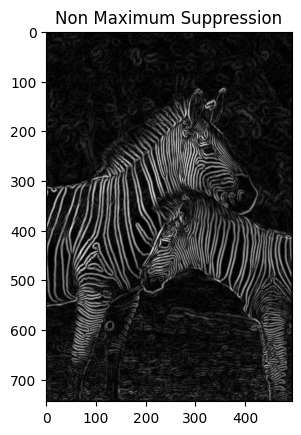

In [ ]:
plt.imshow(grad_mag_nonmax_suppressed, cmap='gray')
plt.title('Non Maximum Suppression');

Now, even if after non-maximum suppresion, we have extracted edges out of the images, we still have some noise in the image. Hence we use the concept of Double Thresholding. In this we have 2 threshold values of gradient magnitudes.

- High Threshold 'H'
- Low threshold 'L'

Pixels with gradient mangnitude higher than H are retained and named 'Strong Edges'. Pixels with gradient magnitude between L and H are termed weak pixels and are retained. Pixels with grad magnitude lower than L are dropped.

We need to come up with a reasonable process to determine the thresholds.

## Thresholding function

We wrap the above block of code in a function to simplify usage.

In [ ]:
'''
Function Name: non_max_threshold
Function description: thresholds gradient magnitudes for suppression of random noise in image after non maximum suppression
Input:
1. img: non maximum suppressed image

Output:
1. : thresholded image
2. : Threshold value
    2.1 H: strong threshold
    2.2 L: weak threshold
'''

def non_max_threshold(img):

    # find maximum, minimum and average values
    maxx, minn, mean, stddev = np.max(img), np.min(img), np.mean(img), np.std(img)

    # define high threshold value
    ## pixels having gradient magnitude above this will be termed strong edges
    ## value of high_threshold_multiplier obtained heuristically
    high_threshold_multiplier = 0.4
    h = maxx*high_threshold_multiplier

    # define low threshold value
    ## pixels haveing gradient magnitude below this will be removed and assigned zero
    ## pixels with magnitude between h and l will be termed weak edges
    ## value of low_threshold_multiplier obtained heuristically
    low_threshold_multiplier = 0.06
    l = h*low_threshold_multiplier

    imgshape = np.shape(img)

    # thresholding
    for i in range(imgshape[0]):
        for j in range(imgshape[1]):
            if img[i, j]<l:
                img[i, j] = 0
            elif img[i, j]>=l and img[i, j]<=h:
                img[i, j] = mean
            else:
                img[i, j] = maxx

    return img, mean, h, l

In [ ]:
heli_threshold_data_img, heli_mean, heli_high, heli_low = non_max_threshold(grad_mag_nonmax_suppressed)

In [ ]:
#plt.imshow(grad_mag_nonmax_suppressed, cmap='gray')

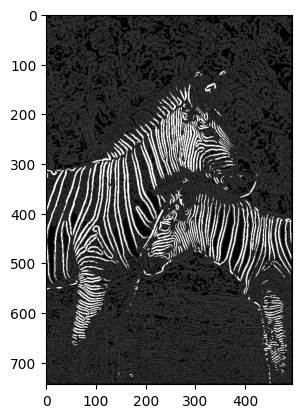

In [ ]:
# Show results here
plt.imshow(heli_threshold_data_img, cmap='gray')
#plt.title('Edge Detection through Non maximum Suppresion and Thresholding');

## Hysterisis for Improved resolution

Here as we can see, there is some loss of data from the image. A hysterisis function cana be implemented to check if there are any strong pixels surrounding a weak pixel. If there are, we can consider that weak pixel as a strong one, if there aren't then we can just term it as a irrelevant pixel.

In [ ]:
import numpy as np
import cv2

def hyst(img, low_threshold, high_threshold):
    # Define the mask for edge pixels found by double thresholding
    strong_edges = (img >= high_threshold)
    candidate_edges = (img >= low_threshold) & (img < high_threshold)

    # Use a connectivity-based approach (8-connected in this case)
    # Create a binary mask for the final edges
    edge_mask = np.zeros_like(img, dtype=np.uint8)
    edge_mask[strong_edges] = 255  # Strong edges are definitely retained

    # Find weak edges that are connected to strong edges
    # Iterate through all the pixels to track connectivity
    height, width = img.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if candidate_edges[i, j]:
                # Check 8-connected neighbors
                if (strong_edges[i - 1:i + 2, j - 1:j + 2].any()):
                    edge_mask[i, j] = 255  # Set as a final edge

    return edge_mask

In [ ]:
# Assuming 'thresholded_img' is your image after double thresholding
edges_after_hyst = hyst(heli_threshold_data_img, low_threshold=50, high_threshold=150)

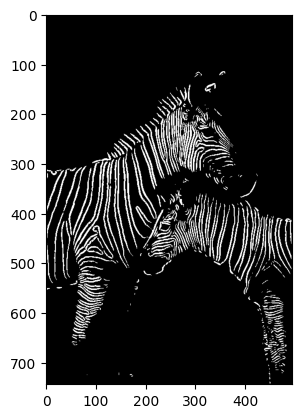

In [ ]:
plt.imshow(edges_after_hyst, cmap='gray')

In [ ]:
'''
Function name: hyst
Function description: performs hysterisis operation over the given image

Input:
1. img: image obtained after passing through double thresholding (which itself is performed after getting an output from non-maximal suppression)

Output:
1. : image obtained after hysterisis operation


def hyst(img):

    imshape = np.shape(img)

    for i in range(1, imshape[0]-1):
        for j in range(1, imshape[1]-1):



'''

SyntaxError: incomplete input (<ipython-input-39-20090e619b1a>, line 20)

In [ ]:
# Demonstrate your understanding by answering the question below:
# Explain how you chose the threshold for non-maximal suppression?



# Task 6: Find the helipad

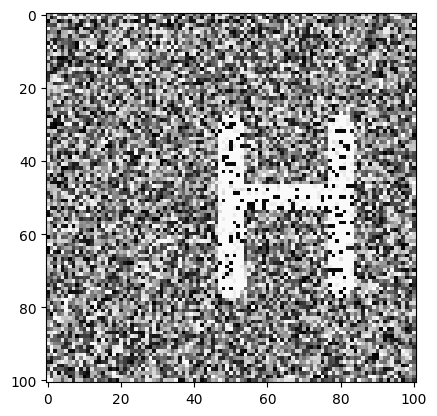

In [ ]:
# Write your code here

# Sub task 1: Load the image
helipad = cv.imread('task6_helipad.png')
plt.imshow(helipad)

# Define gaussian blurring filter
## use the same defined in Task 1

# Define gradient calculation filter
## use same defined in Task 2

In [ ]:
# Sub task 2: Normalise the image
heli_norm = normalize_image(helipad)

Text(0.5, 1.0, 'Blurred Image')

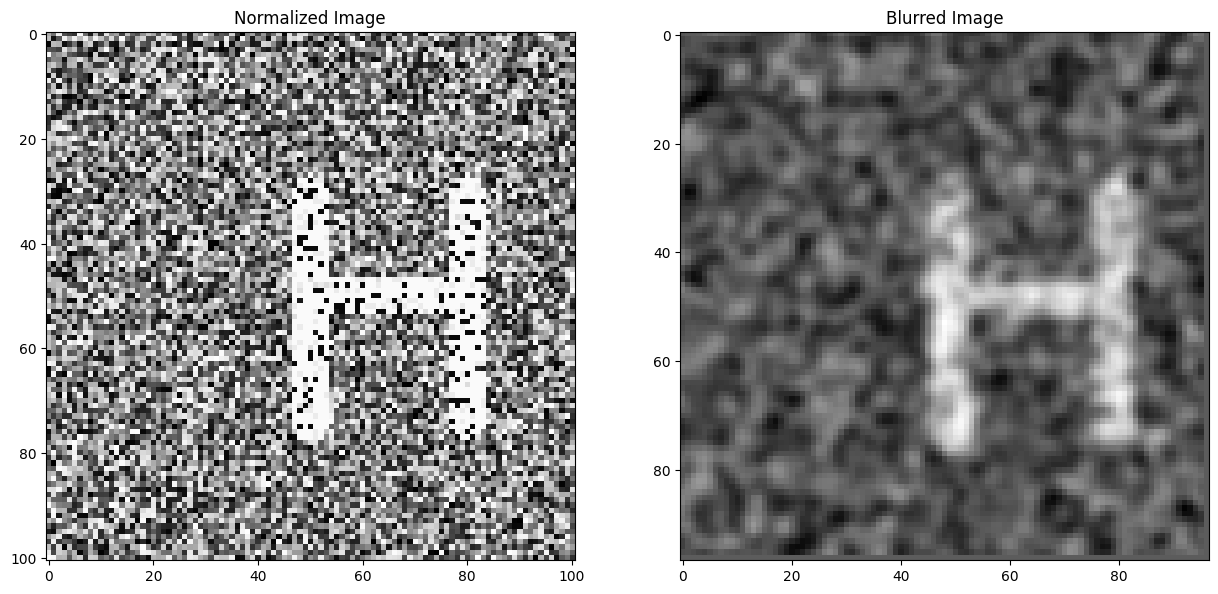

In [ ]:
# Sub task 3: Apply gaussian blurring for filtering
heli_blur = conv(heli_norm, kernel)
fix, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(heli_norm, cmap='gray')
ax[1].imshow(heli_blur, cmap='gray')
ax[0].set_title('Normalized Image')
ax[1].set_title('Blurred Image')

Text(0.5, 1.0, 'Gradient Magnitude of Blurred Helipad Image')

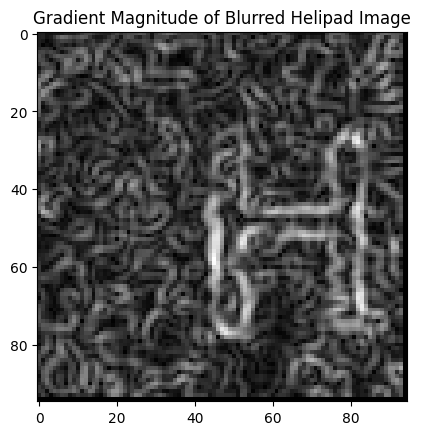

In [ ]:
# Sub task 4: Find gradient data
heli_grad_data = gradmagnitude(heli_blur, sobel)
heli_grad_mag = heli_grad_data[0]
plt.imshow(heli_grad_mag, cmap='gray')
plt.title('Gradient Magnitude of Blurred Helipad Image')

In [ ]:
# Sub task 5: Find gradient orientation data
heli_grad_oreo_data = gradoreoround(heli_blur, sobel, 'deg', 45)

heli_grad_oreo_rounded = heli_grad_oreo_data[0]
heli_grad_oreo_unrounded = heli_grad_oreo_data[1]
heli_gradx = heli_grad_oreo_data[2]
heli_grady = heli_grad_oreo_data[3]
heli_grad_mag = heli_grad_oreo_data[4]

The image has a large number of pixels, hence the effect of rounding off is not apparent if the whole image is viewed. Below, we just plot a part of the image.

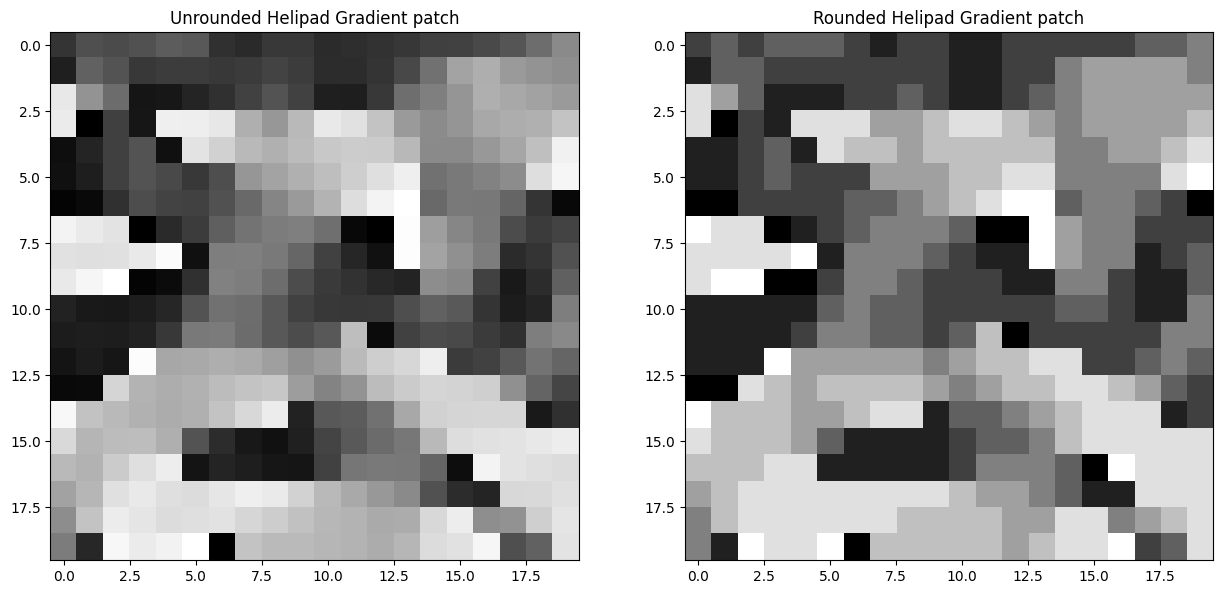

In [ ]:
fix, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[1].imshow(heli_grad_oreo_rounded[0:20, 0:20], cmap='gray')
ax[0].imshow(heli_grad_oreo_unrounded[0:20, 0:20], cmap='gray')
ax[0].set_title('Unrounded Helipad Gradient patch')
ax[1].set_title('Rounded Helipad Gradient patch');

In [ ]:
# Sub task 5: Apply non maximum suppresion operation to curb noise magnitudes
heli_nonmax_suppressed = non_max_suppresion(heli_blur, sobel, 'deg', 45)

# Sub task 6: Perform thresholding
heli_threshold_data = non_max_threshold(heli_nonmax_suppressed)

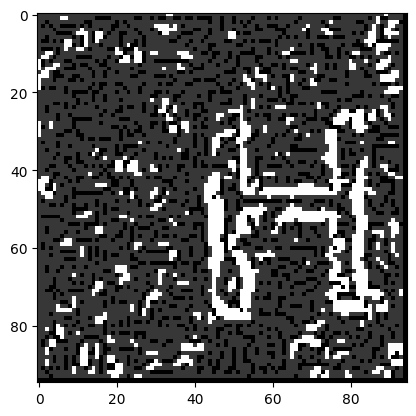

In [ ]:
# Show results here
plt.imshow(heli_threshold_data[0], cmap='gray')

Now, we need to identify the centre of this figure 'H' and mark a symbol. Before we can do that, we have to find the edges. What we have now, is an array of non maximum suppressed gradient magnitude. And we need to find the edges.

In [ ]:
# Demonstrate your understanding by answering the question below:
# How did you adapt your previous code to solve this problem?

# Do not remove or edit the following code snippet.

When submitting your lab, please ensure that you have run the entire notebook from top to bottom. You can do this by clicking "Kernel" and "Restart Kernel and Run All Cells". Make sure the last cell (below) has also been run.

In [ ]:
file_name = str(student_id) + '_Lab1_Submission.py'
cmd = "jupyter nbconvert --to script Lab1_student_template.ipynb --output " + file_name
if(os.system(cmd)):
    print("Error converting to .py")
    print("cmd")